In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os
import random
import numpy as np

def set_seed(seed=42):
    # Set seed for Python's built-in random module
    random.seed(seed)
    
    # Set seed for NumPy
    np.random.seed(seed)
    
    # Set seed for PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    # Ensure deterministic behavior in PyTorch
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
set_seed(42)

# Define the custom dataset
class FlattenedScanNetDataset(Dataset):
    def __init__(self, scene_ids_file, data_dir, embedding_dir):
        self.scene_ids = self._load_scene_ids(scene_ids_file)
        self.data_dir = data_dir
        self.embedding_dir = embedding_dir
        self.embeddings = []
        self.labels = []
        self.scene_ids_list = []

        # Load all scenes and flatten the data
        self._load_all_scenes()

    def _load_scene_ids(self, scene_ids_file):
        with open(scene_ids_file, 'r') as f:
            scene_ids = f.read().splitlines()
        return scene_ids

    def _load_all_scenes(self):
        for scene_id in self.scene_ids:
            # Load the .pth file with coordinates, colors, and labels
            scene_data = torch.load(os.path.join(self.data_dir, f'{scene_id}_vh_clean_2.pth'))
            labels = scene_data[2]  # Assuming labels are provided per point

            # Load the fusion embeddings
            fusion_data = torch.load(os.path.join(self.embedding_dir, f'{scene_id}.pt'))
            embeddings = fusion_data['feat']
            mask = fusion_data['mask_full']

            # Filter embeddings and labels using the mask
            filtered_labels = labels[mask]

            # Convert to tensors if they are not already
            if not isinstance(embeddings, torch.Tensor):
                embeddings = torch.tensor(embeddings, dtype=torch.float32)
            if not isinstance(filtered_labels, torch.Tensor):
                filtered_labels = torch.tensor(filtered_labels, dtype=torch.long)

            filtered_labels[filtered_labels == 255] = 20

            # Append to the main list
            self.embeddings.append(embeddings)
            self.labels.append(filtered_labels)
            self.scene_ids_list.extend([scene_id] * embeddings.shape[0])


        # Concatenate all embeddings and labels to create a flat dataset
        self.embeddings = torch.cat(self.embeddings, dim=0)
        self.labels = torch.cat(self.labels, dim=0)
        print("Label stats:", self.labels.min().item(), self.labels.max().item())


    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx], self.scene_ids_list[idx]

In [2]:
# Paths to your data
train_scene_ids_file = '/projectnb/compvision/charoori/openscene/data/scannet_3d/scannetv2_train_filtered1.txt'
train_data_dir = '/projectnb/compvision/charoori/openscene/data/scannet_3d/train' 
train_embedding_dir = '/projectnb/compvision/charoori/Lexicon3D/lexicon3d/dataset/lexicon3d/dinov2_v2/dinov2_features'

# Create dataset and dataloader
train_dataset = FlattenedScanNetDataset(train_scene_ids_file, train_data_dir, train_embedding_dir)

# Paths to your data
val_scene_ids_file = '/projectnb/compvision/charoori/openscene/data/scannet_3d/scannetv2_val_filtered1.txt'
val_data_dir = '/projectnb/compvision/charoori/openscene/data/scannet_3d/val' 
val_embedding_dir = 

# Create dataset and dataloader
val_dataset = FlattenedScanNetDataset(val_scene_ids_file, val_data_dir, val_embedding_dir)

Label stats: 0 20
Label stats: 0 20


In [3]:
import matplotlib.pyplot as plt
plt.ion()

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
# Define the segmentation model
class SimpleSegmentationModel(nn.Module):
    def __init__(self, input_dim=1024, num_classes=21):
        super(SimpleSegmentationModel, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.fc(x.float())
        pred = self.softmax(x)
        return torch.log(pred)  # Return log-probabilities for NLLLoss

# Training function with dynamic plotting
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=3):
    best_val_loss = np.inf
    patience_counter = 0
    train_losses = []
    val_losses = []

    # Setup the plot
    plt.figure(figsize=(10, 5))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels, _ in train_loader:
            inputs = inputs.to(device, dtype=torch.float32)
            labels = labels.to(device, dtype=torch.long)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            
            running_loss += loss.item()
            print(running_loss)

        # Calculate training loss
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels, _ in val_loader:
                inputs = inputs.to(device, dtype=torch.float32)
                labels = labels.to(device, dtype=torch.long)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        # Calculate validation loss
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

        # Update the plot
        plt.clf()  # Clear the current figure
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss Over Epochs')
        plt.pause(0.001)  # Pause to update the plot

        # Early stopping based on validation loss
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Save the best model
            torch.save(model.state_dict(), f"best_model_dino_{epoch}.pth")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    # Keep the final plot displayed
    plt.ioff()
    plt.show()

3.2545132637023926
6.480662107467651
9.646147966384888
12.764827966690063
15.802287817001343
18.81886887550354
21.775505304336548
24.716940879821777
27.596027851104736
30.428089380264282
33.216007232666016
35.97223877906799
38.68909740447998
41.37358617782593
44.05112910270691
46.62591743469238
49.19087100028992
51.729568004608154
54.2400164604187
56.70161509513855
59.12785363197327
61.5119047164917
63.82327342033386
66.1239583492279
68.40548729896545
70.65857982635498
72.8646297454834
75.03211712837219
77.17388677597046
79.31544351577759
81.42133235931396
83.42863464355469
85.46659779548645
87.48265957832336
89.43692445755005
91.41312050819397
93.34385991096497
95.24381422996521
97.13949036598206
98.99767065048218
100.86454379558563
102.65689480304718
104.43146896362305
106.19628536701202
107.89770722389221
109.62570428848267
111.23117280006409
112.87331938743591
114.47518992424011
116.12283623218536
117.75331318378448
119.3991162776947
120.98800778388977
122.53561091423035
124.055455

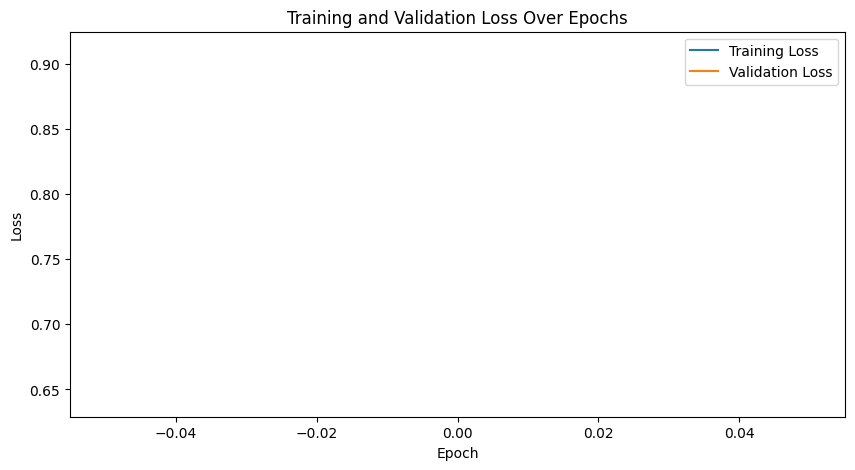

0.6045181155204773
1.221113383769989
1.842618703842163
2.4771679043769836
3.0962806940078735
3.703210175037384
4.356126666069031
4.931161880493164
5.581810414791107
6.177682042121887
6.7686702609062195
7.342409193515778
7.9169058203697205
8.510049819946289
9.140030443668365
9.695466160774231
10.298542499542236
10.886975884437561
11.528498530387878
12.137008249759674
12.735443115234375
13.37002146244049
13.986151039600372
14.64980959892273
15.262059926986694
15.935250103473663
16.5359668135643
17.204606473445892
17.79773736000061
18.427882075309753
19.041244506835938
19.622407138347626
20.203235268592834
20.847160279750824
21.54340022802353
22.17243754863739
22.85218733549118
23.45473438501358
24.08775508403778
24.715144097805023
25.306961357593536
25.955408096313477
26.6161807179451
27.213761389255524
27.82713693380356
28.417284429073334
29.040309965610504
29.676606357097626
30.306320011615753
30.96372663974762
31.578226268291473
32.20985645055771
32.781801998615265
33.39731842279434
3

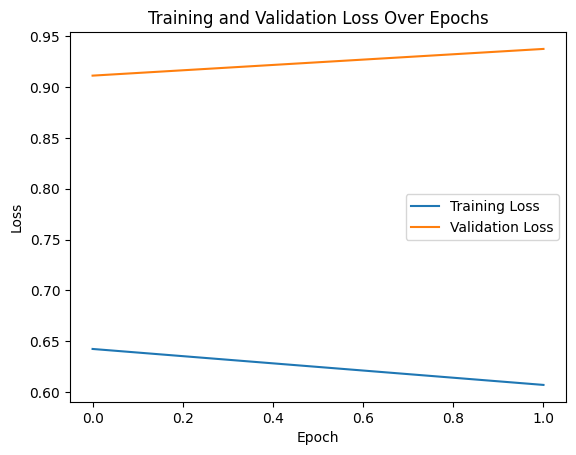

0.6311253905296326
1.2165868282318115
1.845945119857788
2.4035677313804626
3.004907190799713
3.5689491033554077
4.19803661108017
4.8211236000061035
5.380105197429657
5.983491480350494
6.630583584308624
7.2640222907066345
7.817941129207611
8.402128338813782
9.007931888103485
9.615728497505188
10.260543286800385
10.890592992305756
11.494344592094421
12.052602708339691
12.625878155231476
13.201078832149506
13.776714861392975
14.380218505859375
15.008468091487885
15.633012473583221
16.244409024715424
16.82749432325363
17.39977216720581
18.04493820667267
18.666930377483368
19.254128575325012
19.82491022348404
20.474711060523987
21.049193263053894
21.639023780822754
22.220578610897064
22.815058171749115
23.43789565563202
24.068356335163116
24.696215987205505
25.330260515213013
25.915580987930298
26.550698578357697
27.14474105834961
27.765638411045074
28.379782497882843
29.019092738628387
29.630138099193573
30.238068759441376
30.886067986488342
31.46618813276291
32.0663948059082
32.6465722322

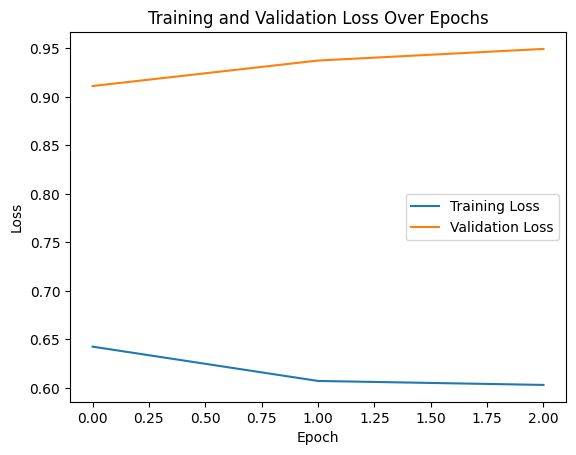

0.6120795011520386
1.1852951049804688
1.7913503050804138
2.3639971017837524
2.9350966215133667
3.546369969844818
4.118313848972321
4.731874525547028
5.326696038246155
5.984452605247498
6.558351755142212
7.112417638301849
7.7127567529678345
8.368939936161041
8.964461982250214
9.589341700077057
10.148641467094421
10.780422866344452
11.401926338672638
12.007566630840302
12.590592682361603
13.227928817272186
13.809292018413544
14.354577958583832
14.957682728767395
15.53689330816269
16.086395621299744
16.672536730766296
17.268959403038025
17.862792193889618
18.48718822002411
19.11606776714325
19.743899941444397
20.38872718811035
20.938012063503265
21.583804845809937
22.151508152484894
22.80321568250656
23.407171845436096
23.97243309020996
24.528881013393402
25.148943960666656
25.772726118564606
26.376841723918915
26.971142172813416
27.522943317890167
28.089971363544464
28.677591621875763
29.303359389305115
29.893031656742096
30.513625919818878
31.19119554758072
31.79165279865265
32.38984400

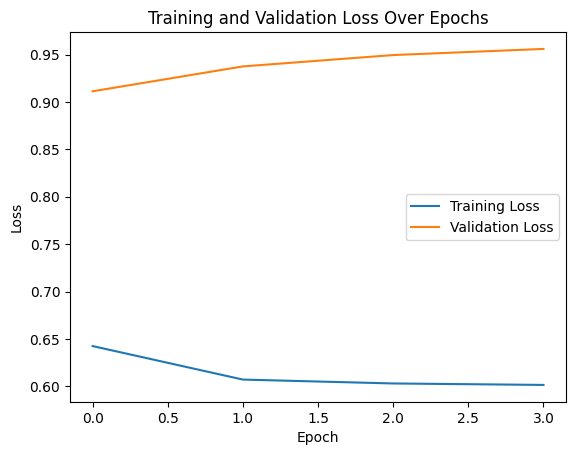

Early stopping at epoch 4


In [19]:
# Hyperparameters and settings
batch_size = 1024  # You can adjust the batch size depending on memory constraints
learning_rate = 0.0001
num_epochs = 10


# Create a generator for the DataLoader
g = torch.Generator()
g.manual_seed(42)

# DataLoader for training and validation with a fixed generator
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=lambda _: set_seed(42), generator=g)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, generator=g)


# Initialize the model, criterion, and optimizer
model = SimpleSegmentationModel(input_dim=1024, num_classes=21).to(device)
criterion = nn.NLLLoss()  # Use NLLLoss since we are providing log-probabilities
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)


0.5775878429412842
1.1701931953430176
1.7657338380813599
2.370615243911743
2.9614264965057373
3.5342800617218018
4.136270463466644
4.756066083908081
5.4121599197387695
6.006943702697754
6.55884450674057
7.2355917096138
7.850222945213318
8.50417047739029
9.09943038225174
9.660123825073242
10.248854398727417
10.851286590099335
11.468570351600647
12.06616061925888
12.739280462265015
13.35575544834137
14.004307985305786
14.574966967105865
15.19497400522232
15.808865487575531
16.43265336751938
17.0277179479599
17.654303073883057
18.23424744606018
18.797454714775085
19.388501167297363
19.987442076206207
20.653185307979584
21.270708680152893
21.826174318790436
22.436649918556213
23.12274008989334
23.738886892795563
24.329167783260345
24.942234754562378
25.595779955387115
26.225321173667908
26.83434957265854
27.508459627628326
28.128294944763184
28.73733162879944
29.288565278053284
29.888008773326874
30.499982476234436
31.08406364917755
31.626866579055786
32.197546541690826
32.775149405002594


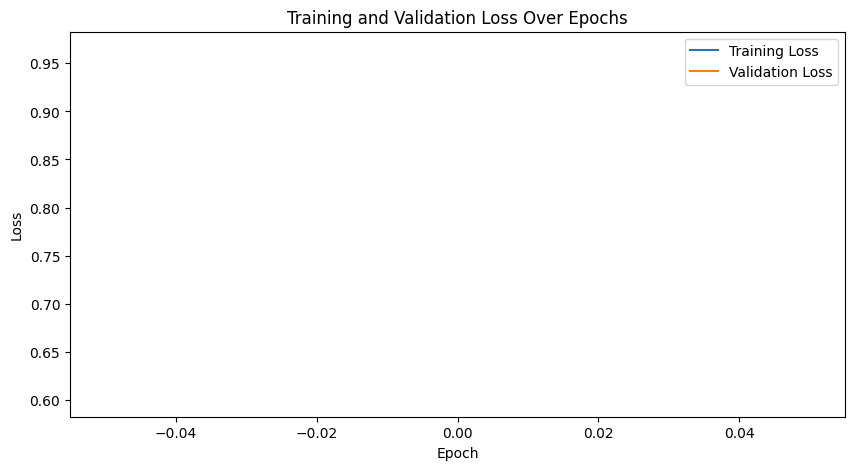

0.6016237735748291
1.229412853717804
1.8249400854110718
2.4454323053359985
3.0306657552719116
3.660891890525818
4.261123180389404
4.846166372299194
5.462164878845215
6.069948136806488
6.707663059234619
7.292693495750427
7.875252664089203
8.488433361053467
9.110055685043335
9.727388679981232
10.373717069625854
10.939332783222198
11.508831799030304
12.099383294582367
12.708277940750122
13.253770291805267
13.846684038639069
14.48503428697586
15.057472348213196
15.614658534526825
16.227990448474884
16.85677570104599
17.479266226291656
18.1393261551857
18.76439279317856
19.337566614151
19.93122923374176
20.58438140153885
21.13453322649002
21.7190899848938
22.371467173099518
22.95515125989914
23.565878748893738
24.11686462163925
24.674769282341003
25.285844445228577
25.911943018436432
26.52218222618103
27.14060926437378
27.720412373542786
28.318491995334625
28.938601195812225
29.48294198513031
30.093134462833405
30.67607605457306
31.31657487154007
31.897320091724396
32.47941470146179
33.0732

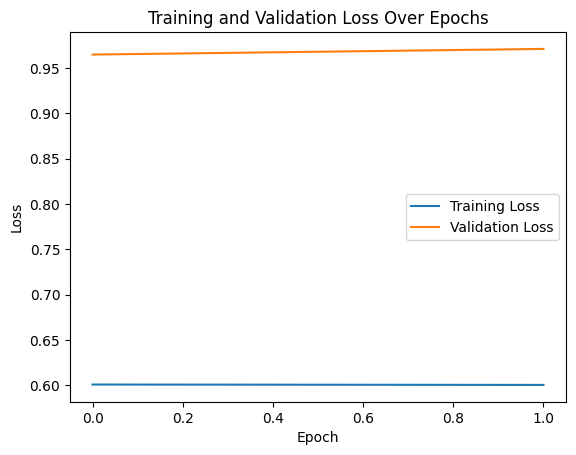

0.5629549622535706
1.2013049721717834
1.8014336824417114
2.3391948342323303
2.929170250892639
3.527408480644226
4.112100601196289
4.684742867946625
5.293670415878296
5.87776517868042
6.507488489151001
7.10579389333725
7.747465193271637
8.340924859046936
8.98778247833252
9.538273453712463
10.16530704498291
10.793823659420013
11.384417176246643
11.954510807991028
12.523638308048248
13.16099625825882
13.779953300952911
14.386608242988586
14.992510080337524
15.577039659023285
16.21882128715515
16.83248484134674
17.454431533813477
18.078990936279297
18.676600635051727
19.260854244232178
19.90340167284012
20.493820905685425
21.096880853176117
21.731363654136658
22.311472713947296
22.879121840000153
23.489069938659668
24.089702367782593
24.668039083480835
25.266862869262695
25.870673060417175
26.51831030845642
27.12018120288849
27.748440086841583
28.40397745370865
28.977570712566376
29.582504272460938
30.186890244483948
30.83059561252594
31.389727771282196
32.02990531921387
32.63814967870712


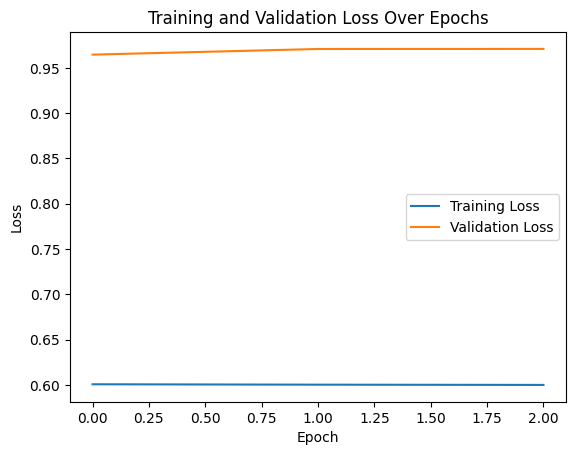

0.55955570936203
1.191533386707306
1.8080039024353027
2.4285327196121216
2.9916117191314697
3.5259034633636475
4.09194540977478
4.65167635679245
5.299386024475098
5.9173136949539185
6.534031391143799
7.1816858649253845
7.782800734043121
8.377123355865479
8.960524260997772
9.592444777488708
10.196022987365723
10.798318266868591
11.378137111663818
11.94705867767334
12.53743588924408
13.196560621261597
13.774530291557312
14.39035552740097
15.007479429244995
15.64651244878769
16.230237543582916
16.79088717699051
17.37525463104248
17.99461007118225
18.581834316253662
19.156219363212585
19.760151088237762
20.351796209812164
20.943865656852722
21.574382603168488
22.148665964603424
22.70888078212738
23.257515490055084
23.83559274673462
24.424048483371735
25.102331042289734
25.685855269432068
26.239656507968903
26.802941262722015
27.384640753269196
28.008618354797363
28.58439600467682
29.216430068016052
29.79513841867447
30.382325291633606
31.010657131671906
31.61877715587616
32.24234199523926


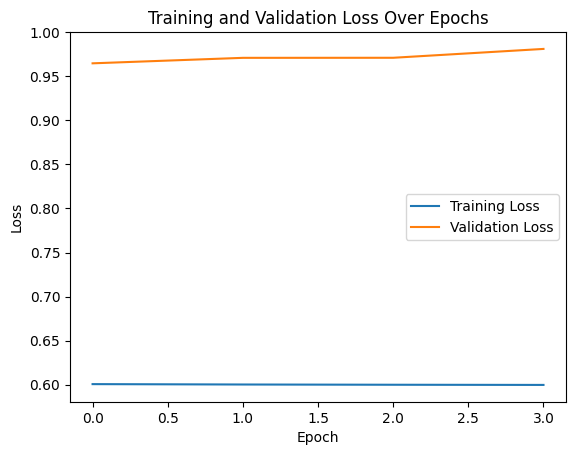

Early stopping at epoch 4


In [20]:
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)